# Самостоятельная домашняя работа №1 от Бондаренко Алексея (bondaleksey@gmail.com)
Основные пункты задания: 


*   EDA для выбранного датасета
*   Preprocessing
*   Построение моделей из коробки и проверка качества
*   Настройка гиперпараметров моделей и проверка качества

In [68]:
import numpy as np 
import pandas as pd


# для работы с графиками 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
def annot_plot(ax,w,h):                                    # function to add data to plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for p in ax.patches:
         ax.annotate(f"{p.get_height() * 100 / df.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='black', rotation=0, xytext=(0, 10),
         textcoords='offset points') 



from sklearn.model_selection import train_test_split

# 1 Данные


## 1.1 Загрузка данных
В качестве данных используется набор [IBM Watson Marketing Data Analysis](https://www.kaggle.com/pankajjsh06/ibm-watson-marketing-customer-value-data)

In [64]:
url = "https://drive.google.com/file/d/1aSPmZlNVLpbcFOmNy9mJy7Nvr2xc7rmN/view?usp=sharing"
url2= "https://drive.google.com/uc?id=" + url.split('/')[-2]
df = pd.read_csv(url2)
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [47]:
df.shape

(9134, 24)

Преобразуем целевое значение из категориального в количественный тип данных

# 2 Исследовательский анализ данных (EDA)



## 2.1 Первичная стастика

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   int64  
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

В данном наборе данных 
  
*   нет NaN значений
*   8 количественных переменных
*   16 категориальных переменных




In [51]:
df.describe()

,Customer Lifetime Value,Response,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,0.143201,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794
std,6870.967608,0.350297,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092
min,1898.007675,0.000000,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007
25%,3994.251794,0.000000,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244
50%,5780.182197,0.000000,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434
75%,8962.167041,0.000000,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839
max,83325.381190,1.000000,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678


Разобъем переменные на категориальные и количественные

In [82]:
# названия категориальных переменных, которые создатут не более
# 4 дополнительных столбцов при onehotencoding 
categorical_cols = [cname for cname in df.columns if
                    df[cname].nunique() < 7 and 
                    df[cname].dtype == "object"]

# названия количественных переменных
numerical_cols = [cname for cname in df.columns if 
                df[cname].dtype in ['int64', 'float64']]

print(f"Число категориальных переменных: {len(categorical_cols)}")
print(f"Число количесвтенных переменных: {len(numerical_cols)}")
print(f"Из рассмотрения исключены: {len(df.columns)-len(numerical_cols)-len(categorical_cols)} категориальных переменных ")

Число категориальных переменных: 13
Число количесвтенных переменных: 8
Из рассмотрения исключены : 3 категориальных переменных 


## 2.2 Анализ количественных данных

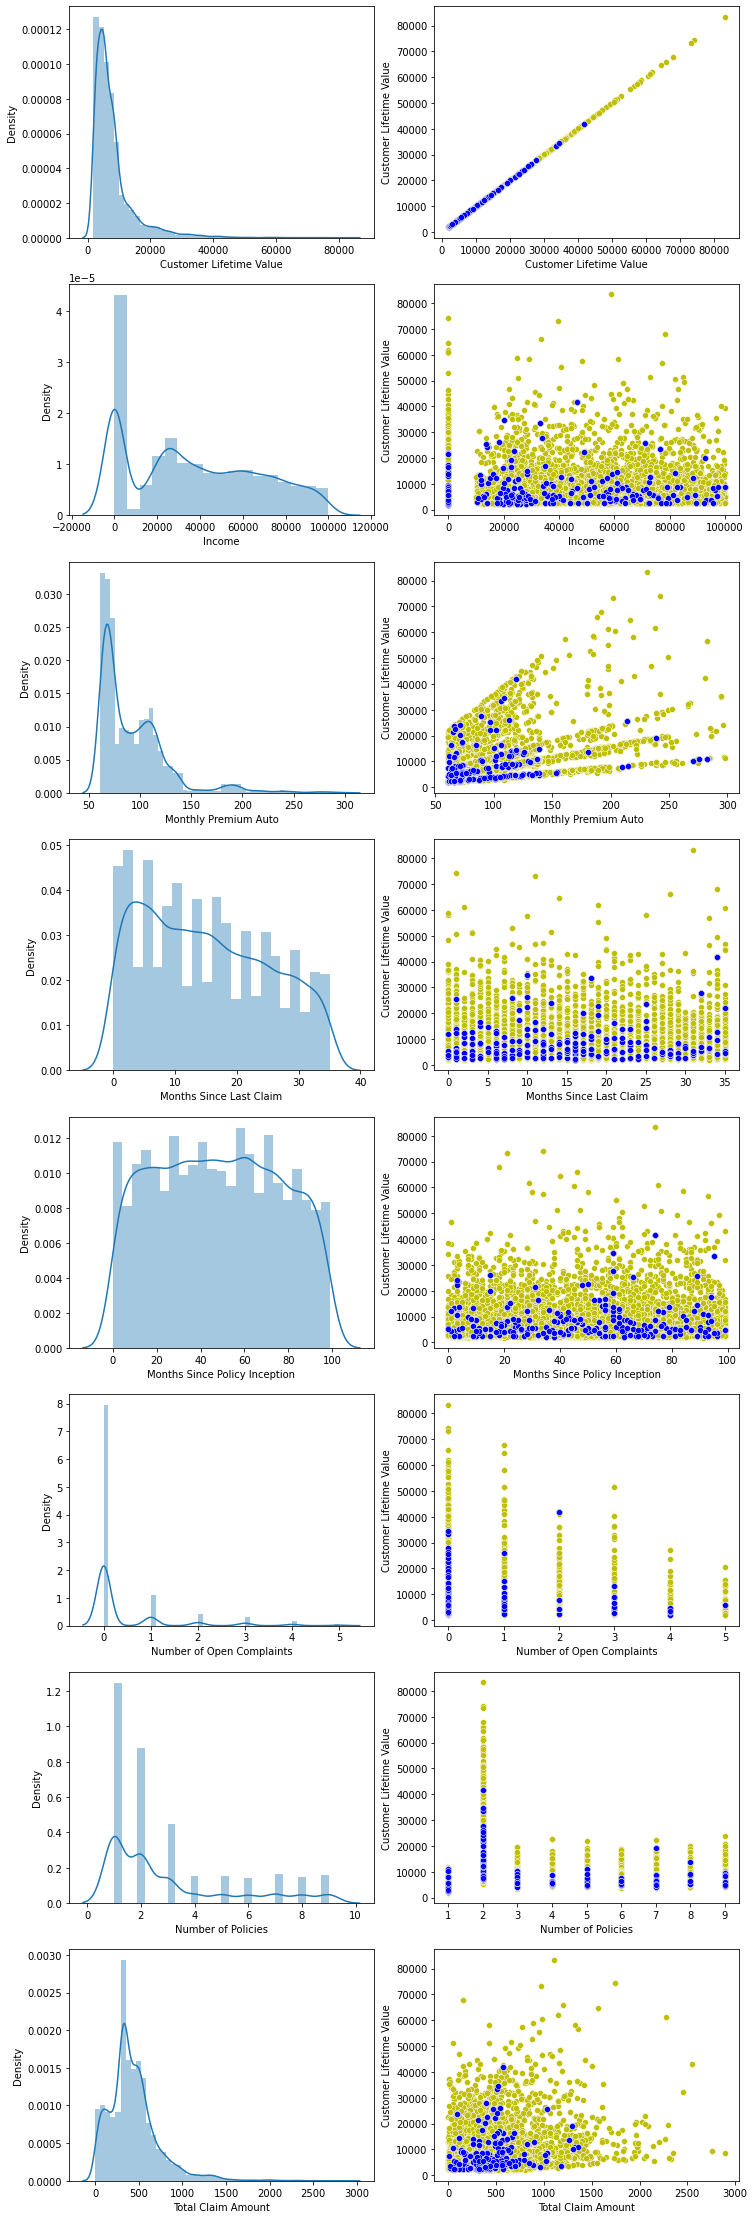

In [66]:
plt.figure(figsize=(12,40))

for i, val in enumerate(numerical_cols):
  plt.subplot(len(numerical_cols), 2, 2*(i+1)-1)  
  sns.distplot(df[val])  
  plt.subplot(len(numerical_cols), 2, 2*(i+1))  
  sns.scatterplot(df[val][df['Response']=='No'],df["Customer Lifetime Value"][df['Response']=='No'],color='y')
  sns.scatterplot(df[val][df['Response']=='Yes'],df["Customer Lifetime Value"][df['Response']=='Yes'],color='b')
  


## 2.3 Анализ категориальных параметров

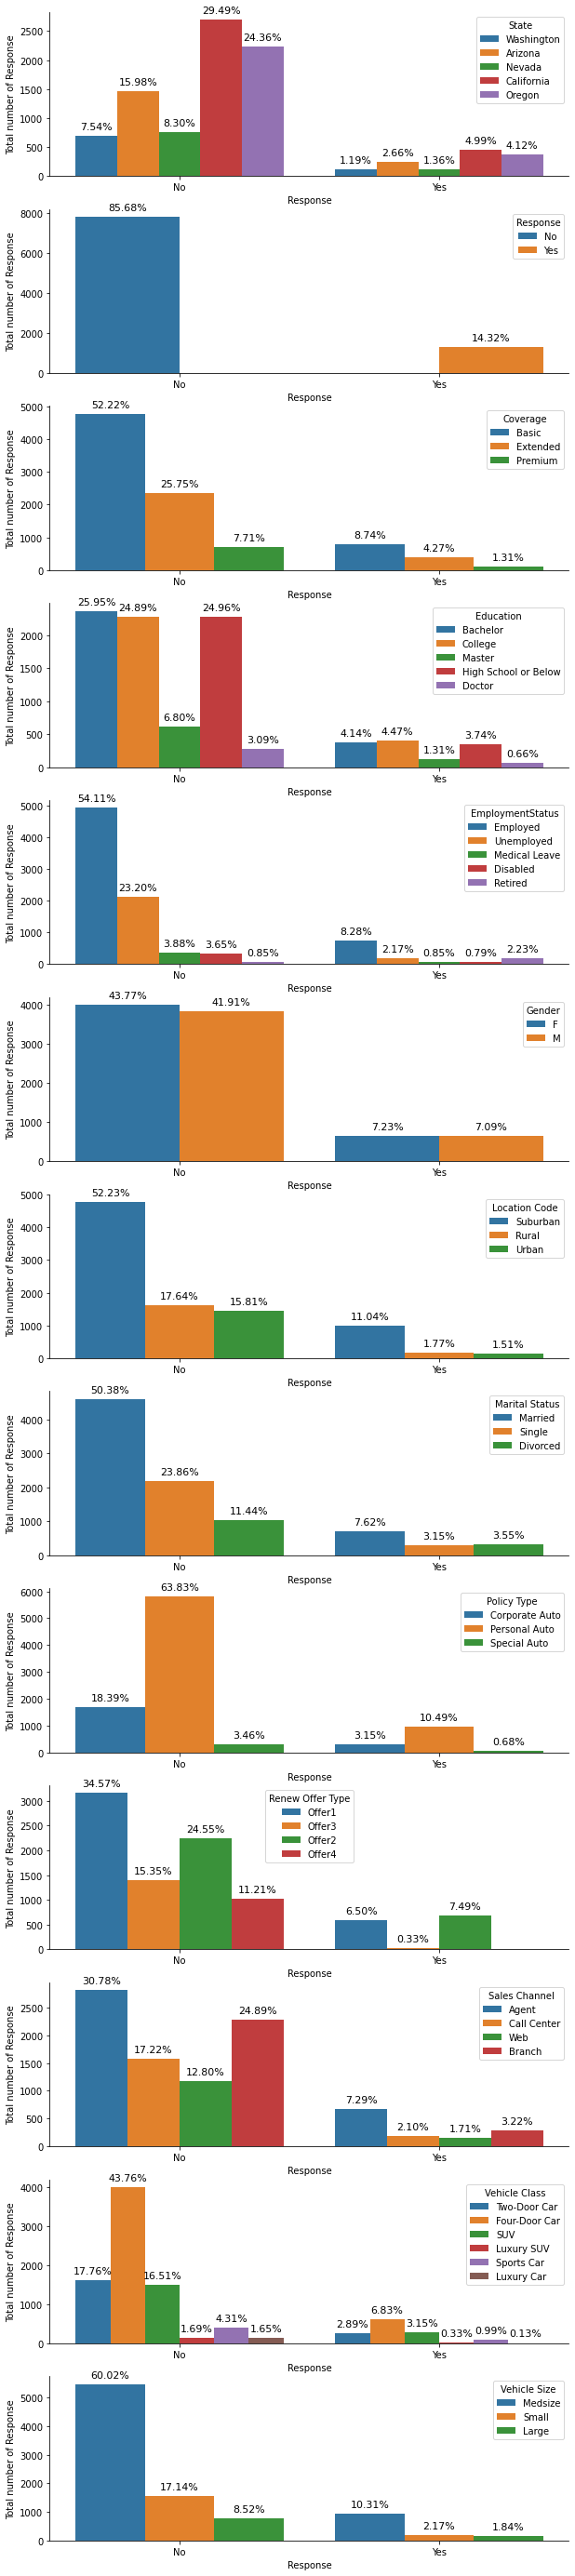

In [89]:
#plt.figure(figsize=(12,40))
# plt.figure(figsize=(8,10))
plt.figure(figsize=(10,50))

for i, val in enumerate(categorical_cols):
  plt.subplot(len(categorical_cols), 1, i+1)
  ax = sns.countplot('Response', hue = val ,data = df)
  plt.ylabel(f'Total number of Response')
  annot_plot(ax, 0.1,1)

# 3 Предобработка данных

## 3.1 Изменение значений категориальных переменных
надо применить  [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [48]:
# надо поменять на применение (LabelEncoder)[https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html]
df['Response'] = df['Response'].apply(lambda X : 0 if X == 'No' else 1)
# X_full
print(df.shape)
#print(X_full.shape)

(9134, 24)


In [49]:
df.head()



,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,0,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,0,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,0,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,0,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,0,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


## 3.2 Разбиение данных 
Проведем разбиение данных на
*   train
*   validate


 



In [52]:
# разделили target и predictors
y = df['Response']
X_full = df.drop(['Response'], axis=1)


# разиение данных
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.7, test_size=0.3,
                                                                random_state=42)



my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
#X_test = X_test_full[my_cols].copy()
print(X_train.shape)
print(X_valid.shape)
print(categorical_cols)
print(numerical_cols)
print(y.dtype)

(6393, 16)
(2741, 16)
['Coverage', 'Gender', 'Location Code', 'Marital Status', 'Policy Type', 'Renew Offer Type', 'Sales Channel', 'Vehicle Size']
['Customer Lifetime Value', 'Income', 'Monthly Premium Auto', 'Months Since Last Claim', 'Months Since Policy Inception', 'Number of Open Complaints', 'Number of Policies', 'Total Claim Amount']
int64


# 4 Построение модели

## 4.1 Построение Pipelines

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Preprocessing for numerical data
# numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        # ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])



# 5 Выбор гиперпараметров

# Заключение